In [2]:
import torch

from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

2024-05-06 08:52:06.569837: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-06 08:52:06.835246: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 08:52:06.835314: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 08:52:06.875676: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-06 08:52:07.526229: I tensorflow/core/platform/cpu_feature_guar

In [3]:
# Define the simulator. This is one of the TWO bottlenecks of the pipeline
def Simulator(theta):
    omega, phi = theta
    trace = torch.zeros((1,100))
    for t in np.arange(0, 10, 0.1):
        trace[0,int(t*10)] = np.sin(omega * t + phi)
    return trace.reshape_as(torch.zeros((100)))

true_theta = torch.tensor([1, 1])

In [4]:
Simulator(true_theta)

tensor([ 0.8415,  0.8912,  0.9320,  0.9636,  0.9854,  0.9975,  0.9996,  0.9917,
         0.9738,  0.9463,  0.9093,  0.8632,  0.8085,  0.7457,  0.6755,  0.5985,
         0.5155,  0.4274,  0.3350,  0.2392,  0.1411,  0.0416, -0.0584, -0.1577,
        -0.2555, -0.3508, -0.4425, -0.5298, -0.6119, -0.6878, -0.7568, -0.8183,
        -0.8716, -0.9162, -0.9516, -0.9775, -0.9937, -0.9999, -0.9962, -0.9825,
        -0.9589, -0.9258, -0.8835, -0.8323, -0.7728, -0.7055, -0.6313, -0.5507,
        -0.4646, -0.3739, -0.2794, -0.1822, -0.0831,  0.0168,  0.1165,  0.2151,
         0.3115,  0.4048,  0.4941,  0.5784,  0.6570,  0.7290,  0.7937,  0.8504,
         0.8987,  0.9380,  0.9679,  0.9882,  0.9985,  0.9989,  0.9894,  0.9699,
         0.9407,  0.9022,  0.8546,  0.7985,  0.7344,  0.6630,  0.5849,  0.5010,
         0.4121,  0.3191,  0.2229,  0.1245,  0.0248, -0.0752, -0.1743, -0.2718,
        -0.3665, -0.4575, -0.5440, -0.6251, -0.6999, -0.7677, -0.8278, -0.8797,
        -0.9228, -0.9566, -0.9809, -0.99

$$
x(t) = Ae^{-\frac{bt}{2m}} \cos{(\omega_{damp}t + \phi)}
$$

$$
\omega_{damp} = \frac{k}{m} - \frac{b^2}{4m^2}
$$

In [5]:
# Define the prior. PRIOR is used to sample (and only for that)
Prior = utils.BoxUniform(low=torch.tensor([0.0, 0.0]), high=torch.tensor([5.0, 5.0]))

In [6]:
# This cell is a safety check to ensure everything returns the right type of object. These function effectvley create
# new functions that adhere to the sbi API. They are not necessary to understand, but they are necessary to run the code.

# Check prior, return PyTorch prior.
Prior, num_parameters, prior_returns_numpy = process_prior(Prior)

# Check simulator, returns PyTorch simulator able to simulate batches.
Simulator = process_simulator(Simulator, Prior, prior_returns_numpy)

# Consistency check after making ready for sbi.
check_sbi_inputs(Simulator, Prior)

In [7]:
# This is the meat of the method. TODO: Understand this better!!
inference = SNPE(prior=Prior)

In [8]:
# THE SIMULATION CAN BE DONE ELSEWHERE!!! With this function it seems that the prior is sampled randomly.
# This bitch don't parallelize, its a lie!!
theta, x = simulate_for_sbi(Simulator, proposal=Prior, num_simulations=10000, num_workers=1)
theta

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor([[0.9621, 1.3047],
        [1.7064, 3.0654],
        [3.7903, 4.9122],
        ...,
        [2.5076, 1.7802],
        [3.3400, 3.2783],
        [4.4004, 2.5652]])

In [9]:
print("Shape theta", theta.shape)
print("Shape x: ", x.shape)

Shape theta torch.Size([10000, 2])
Shape x:  torch.Size([10000, 100])


In [ ]:
inference = inference.append_simulations(theta, x) # Give the simulations to the inference objects! This is where we would use our simulation

In [ ]:
# Seems like smaller batch sizes are better for training. See: https://stats.stackexchange.com/questions/164876/what-is-the-trade-off-between-batch-size-and-number-of-iterations-to-train-a-neu

# Idea: use multi-round inference to get better results. See: https://sbi-dev.github.io/sbi/tutorial/03_multiround_inference/

density_estimator = inference.train() # This is almost a neural network object (there are more things inside, to be understoo better)

 Neural network successfully converged after 159 epochs.

In [ ]:
posterior = inference.build_posterior(density_estimator)

print(posterior) # prints how the posterior was trained

Posterior conditional density p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


In [7]:
theta_true = torch.tensor([[1.0, 1.0]])
# generate our observation
x_obs = Simulator(theta_true)
x_obs.shape

torch.Size([1, 100])

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

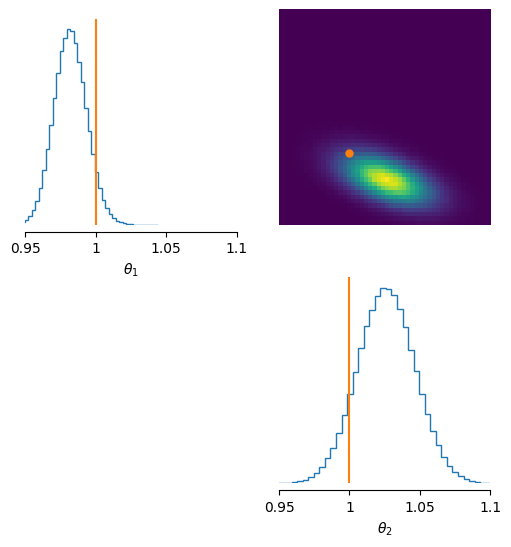

In [ ]:
samples = posterior.sample((1000000,), x=x_obs)
_ = analysis.pairplot(samples, points=theta_true, limits=[[0.95, 1.1], [0.95, 1.1]], figsize=(6, 6), labels=[r"$\theta_1$", r"$\theta_2$"])

# I really don't like this error! More samples don't seem to help. The distribution is the same anyway... Look at the multi-round inference
# More simulation to train the neural network in this case worsened the results...
# See plot in the end of the notebook for visual error

In [ ]:
# first sample an alternative parameter set from the prior
theta_diff = Prior.sample((1,))

In [ ]:
log_probability_true_theta = posterior.log_prob(theta_true, x=x_obs)
log_probability_diff_theta = posterior.log_prob(theta_diff, x=x_obs)
log_probability_samples = posterior.log_prob(samples, x=x_obs)

print( r'high for true theta :', log_probability_true_theta)
print( r'low for different theta :', log_probability_diff_theta)
print( r'range of posterior samples: min:', torch.min(log_probability_samples),' max :', torch.max(log_probability_samples))

high for true theta : tensor([5.6236])
low for different theta : tensor([-3766.6738])
range of posterior samples: min: tensor(-8.3609)  max : tensor(6.1805)


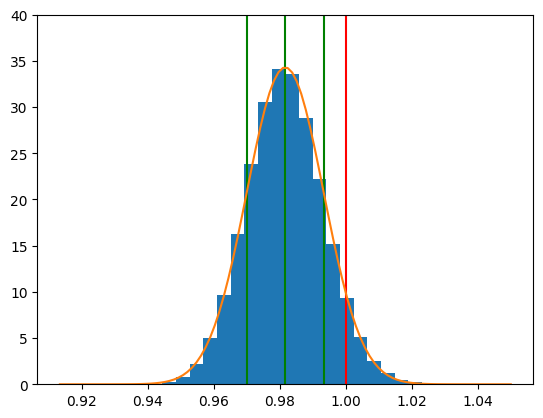

In [ ]:
# This is really bad! The true value is outside one sigma!!

data = samples[:,0]
mean,std=norm.fit(data)
plt.hist(data, bins=30, density=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mean, std)
plt.vlines(x=mean, ymin=0, ymax=40, color='g')
plt.ylim(0, 40)
plt.vlines(x=mean-std, ymin=0, ymax=40, color='g')
plt.vlines(x=mean+std, ymin=0, ymax=40, color='g')
plt.vlines(x=theta_true[0,0], ymin=0, ymax=40, color='r')
plt.plot(x, y)
plt.show()